In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random 
import pandas as pd
from pyomo.environ import *
from shapely.geometry import LineString
import itertools
import os
from pyomo import environ as pe

os.environ['NEOS_EMAIL'] = 'XXXXXX@gmail.com' 

In [2]:
D =['0   0 1 0 ', 
'        00',
' 00   1   ',
'     1  11',
'0  1  11 0',
'1 01  1   ',
' 0  1  0 0',
'   0 0 0 1',
' 00       ',
'  00   0  ',]

D = [
'    0 1 0   ',
'  1   00  10',
'  1         ',
'     1 00 0 ',
'           1',
'      1 0 11',
'011         ',
'       0 00 ',
'   11  0    ',
'          00',
'1  0 1  0   ',
'    11 1   0']

data = {}
counter = 0
Nr , Nc= len(D), len(D)
for r in range(Nr):
    for c in range(Nc):
        s= D[r][c]
        if s in ['0','1']:
            data[r+1,c+1] =  int(s)            
        else:
            data[r+1,c+1] =  -100            
data

{(1, 1): -100,
 (1, 2): -100,
 (1, 3): -100,
 (1, 4): -100,
 (1, 5): 0,
 (1, 6): -100,
 (1, 7): 1,
 (1, 8): -100,
 (1, 9): 0,
 (1, 10): -100,
 (1, 11): -100,
 (1, 12): -100,
 (2, 1): -100,
 (2, 2): -100,
 (2, 3): 1,
 (2, 4): -100,
 (2, 5): -100,
 (2, 6): -100,
 (2, 7): 0,
 (2, 8): 0,
 (2, 9): -100,
 (2, 10): -100,
 (2, 11): 1,
 (2, 12): 0,
 (3, 1): -100,
 (3, 2): -100,
 (3, 3): 1,
 (3, 4): -100,
 (3, 5): -100,
 (3, 6): -100,
 (3, 7): -100,
 (3, 8): -100,
 (3, 9): -100,
 (3, 10): -100,
 (3, 11): -100,
 (3, 12): -100,
 (4, 1): -100,
 (4, 2): -100,
 (4, 3): -100,
 (4, 4): -100,
 (4, 5): -100,
 (4, 6): 1,
 (4, 7): -100,
 (4, 8): 0,
 (4, 9): 0,
 (4, 10): -100,
 (4, 11): 0,
 (4, 12): -100,
 (5, 1): -100,
 (5, 2): -100,
 (5, 3): -100,
 (5, 4): -100,
 (5, 5): -100,
 (5, 6): -100,
 (5, 7): -100,
 (5, 8): -100,
 (5, 9): -100,
 (5, 10): -100,
 (5, 11): -100,
 (5, 12): 1,
 (6, 1): -100,
 (6, 2): -100,
 (6, 3): -100,
 (6, 4): -100,
 (6, 5): -100,
 (6, 6): -100,
 (6, 7): 1,
 (6, 8): -100,
 (6, 9): 0

In [13]:
Nc

12

In [14]:
def draw(L, LW=1):
    if LW > 1:
        LW =8
        plt.plot([L[0][0],L[1][0]], [L[0][1],L[1][1]], lw=LW)
    else:
        plt.plot([L[0][0],L[1][0]], [L[0][1],L[1][1]], lw=2, c= 'k')

In [36]:
M = 2** (Nc+1)
model = AbstractModel()

model.r = RangeSet(Nr)
model.c = RangeSet(Nc)


model.U = Var(model.r,model.c,bounds=(0,1), within=Binary)
model.Vr = Var(model.r,bounds=(1,2**Nc),initialize=1, within=Reals)
model.Vc = Var(model.c,bounds=(1,2**Nc),initialize=1, within=Reals)

model.diff_c = Var(model.c,model.c,bounds=(0,1),initialize=0, within=Binary)
model.diff_r = Var(model.r,model.r,bounds=(0,1),initialize=0, within=Binary)


def rule_C1(model,c):
    return sum( model.U[r,c] for r in model.r) == (Nc/2)
model.C1 = Constraint(model.c, rule=rule_C1)

def rule_C2(model,r):
    return sum( model.U[r,c] for c in model.c) == (Nr/2)
model.C2 = Constraint(model.r, rule=rule_C2)


def rule_C3A(model,c,r):
    if r+2<=Nr:
        return model.U[r,c]+ model.U[r+1,c] + model.U[r+2,c] <= 2
    else:
        return Constraint.Skip
model.C3A = Constraint(model.c,model.r, rule=rule_C3A)


def rule_C3B(model,c,r):
    if r+2<=Nr:
        return model.U[r,c]+ model.U[r+1,c] + model.U[r+2,c] >= 1
    else:
        return Constraint.Skip
model.C3B = Constraint(model.c,model.r, rule=rule_C3B)


def rule_C4A(model,c,r):
    if c+2<=Nc:
        return model.U[r,c]+ model.U[r,c+1] + model.U[r,c+2] <= 2
    else:
        return Constraint.Skip
model.C4A = Constraint(model.c,model.r, rule=rule_C4A)


def rule_C4B(model,c,r):
    if c+2<=Nc:
        return model.U[r,c]+ model.U[r,c+1] + model.U[r,c+2] >= 1
    else:
        return Constraint.Skip
model.C4B = Constraint(model.c,model.r, rule=rule_C4B)

def rule_C5(model,c):
    return sum( (2**(r-1))*model.U[r,c] for r in model.r) == model.Vc[c]
model.C5 = Constraint(model.c, rule=rule_C5)


def rule_C6(model,r):
    return sum( (2**(c-1))*model.U[r,c] for c in model.c) == model.Vr[r]
model.C6 = Constraint(model.c, rule=rule_C6)


def rule_C7A(model,c1,c2):
    if c1>c2:
        return model.Vc[c1]-model.Vc[c2] >= 1 - M*(1-model.diff_c[c1,c2])
    else:
        return Constraint.Skip
model.C7A = Constraint(model.c,model.c, rule=rule_C7A)


def rule_C7B(model,c1,c2):
    if c1>c2:
        return model.Vc[c1]-model.Vc[c2] <= -1 + M*model.diff_c[c1,c2]
    else:
        return Constraint.Skip
model.C7B = Constraint(model.c,model.c, rule=rule_C7B)


def rule_C8A(model,r1,r2):
    if r1>r2:
        return model.Vr[r1]-model.Vr[r2] >= 1 - M*(1-model.diff_r[r1,r2])
    else:
        return Constraint.Skip
model.C8A = Constraint(model.r,model.r, rule=rule_C8A)


def rule_C8B(model,r1,r2):
    if r1>r2:
        return model.Vr[r1]-model.Vr[r2] <= -1 + M*model.diff_r[r1,r2]
    else:
        return Constraint.Skip
model.C8B = Constraint(model.r,model.r, rule=rule_C8B)


def rule_OF(model):
    return  sum(model.U[r,c] for r in model.r for c in model.c) 
model.obj1 = Objective(rule=rule_OF, sense=minimize)
instance = model.create_instance()  


In [37]:
opt = SolverFactory('cbc')
opt.options = {'sec': 1600, 'threads': 4, 'ratio': 0.4}

In [38]:
for r in instance.r:
    for c in instance.c:
        if data[r,c]>=0:
            instance.U[r,c].fix(data[r,c])

In [39]:

results = opt.solve(instance)

from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal and nothing more")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print ('ERROR ' + str(results.solver))
print('OF= ', value(instance.obj1) )

this is feasible and optimal and nothing more
OF=  72.0


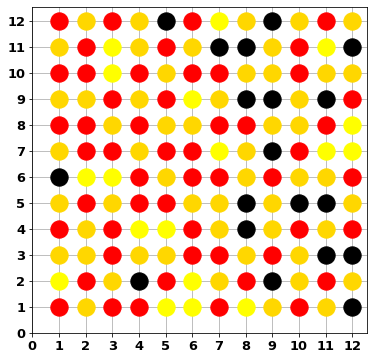

In [41]:
plt.figure(figsize=(6,6))

KOLOR = ['grey','k','grey','y']

for (r,c) in data:
    vv = value(instance.U[r,c])
    if vv==0 and data[r,c] == 0 :
        ss= 300
        K = 'k'
    elif vv==0 and data[r,c] == -100 :
        ss= 300
        K = 'r'  
    elif vv==1 and data[r,c] == 1 :
        ss= 300
        K = 'yellow'  
    if vv==1 and data[r,c] == -100 :
        ss= 300
        K = 'gold'  
    plt.scatter(c,1+Nr-r,s=ss, c=K, zorder=3)
plt.xticks(range(Nr+1), fontweight='bold', fontsize=13)
plt.yticks(range(Nr+1), fontweight='bold', fontsize=13)

plt.savefig(f'Bonairo puzzle   .png', format='png', dpi=400)
plt.grid()

plt.show()

In [28]:
D =[
'0   0 1 0 ', 
'        00',
' 00   1   ',
'     1  11',
'0  1  11 0',
'1 01  1   ',
' 0  1  0 0',
'   0 0 0 1',
' 00       ',
'  00   0  ',]

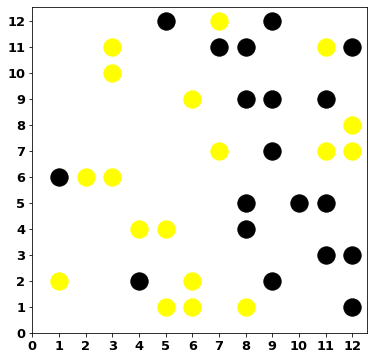

In [42]:
plt.figure(figsize=(6,6))

KOLOR = ['grey','k','grey','y']

for (r,c) in data:
    vv = value(instance.U[r,c])
    if vv==0 and data[r,c] == 0 :
        ss= 300
        K = 'k'
    elif vv==0 and data[r,c] == -100 :
        ss= 300
        K = 'w'  
    elif vv==1 and data[r,c] == 1 :
        ss= 300
        K = 'yellow'  
    if vv==1 and data[r,c] == -100 :
        ss= 300
        K = 'w'  
    plt.scatter(c,1+Nr-r,s=ss, c=K, zorder=3)
plt.xticks(range(Nr+1), fontweight='bold', fontsize=13)
plt.yticks(range(Nr+1), fontweight='bold', fontsize=13)

plt.savefig(f'Base Bonairo puzzle   .png', format='png', dpi=400)

plt.show()

In [12]:
for c in instance.c:
    print(c, value(instance.Vc[c]))
   

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
